# Simulación virtual de contagio adaptado al COVID-19

Este estudio pretende mostrar una demostración práctica (Simulación Virtual) sobre dos escenarios de contagio distintos: 

En el primero de ellos muestra una situación normal. Con una media de 1 a 6 contactos diarios entre personas. 

En el segundo se intenta reflejar una situación con estado de alarma. Con una media de 0 a 4 contactos diarios entre personas. 

Los pasos del **algoritmo** son: 

1. Creación de una población virtual (10 millones de habitantes) 
2. Generación de relaciones entre los individuos, serán los canales que utilizará el virus para propagarse. 
3. Se infectará al azar a 3 individuos 
4. Se simulará día a día, en cada día los individuos contagiados podrán trasferir el virus con una determinada probabilidad a aquellos con los que se hayan relacionado. 
5. Una vez contagiado un individuo entra en un periodo de incubación de dos días. Durante la incubación el individuo no podrá contagiar. A los 12 días de contagiarse cada individuo para curarse con un 95% de probabilidad o fallecer. Los individuos que superén la enfermedad no pueden volver a ser contagiados.

In [1]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Genera los individuos de la población

In [2]:
#Lista de personas
def generaPoblacion ():
    
    poblacion = []

    for i in range (tam_poblacion):
        persona = {"Id": i, 
                   "Estado": 0, 
                   "Dias_Contagiado": -1, 
                   #"Dia_Contagio":-1, 
                   #"Usuario_Contagia": -1
                  }
        poblacion.append(persona)
    
    return poblacion

### Genera las relaciones entre la población

In [3]:
#Relaciones entre las personas
def generaRelaciones ():
   
    relaciones = []

    for i in range (tam_poblacion):
        relacion = []
        #Cada persona se relación con otras un número aleatorio de veces
        num_relaciones = random.randint(num_relaciones_min, num_relaciones_max)
    
        for j in range(num_relaciones):    
            index = random.randint(0, tam_poblacion-1)
            #Control para no relacionar consigo mismo
            while index == i:
                index = random.randint(0, tam_poblacion-1)
            relacion.append(index)
        relaciones.append(relacion)
    
    return relaciones

### Infectamos individuos al azar 

In [4]:
def inicializaContagios (poblacion):
    for i in range(num_infectados_init):
        poblacion[random.randint(0, tam_poblacion-1)]['Estado'] = 1
    
    return poblacion

### Simulación

In [5]:
def simulacion (poblacion, relaciones):
    resultados = []

    for dia in range(num_iteraciones):
    
        positivos = 0
        negativos = 0
        curados = 0
        fallecidos = 0
    
        for i in range(tam_poblacion):
        
            #Negativo
            if poblacion[i]['Estado'] == 0:
                negativos  += 1
            
            #Positivo
            elif poblacion[i]['Estado'] == 1:
                positivos += 1
                poblacion[i]['Dias_Contagiado'] += 1 
            
                #Incubación
                if poblacion[i]['Dias_Contagiado'] >= num_dias_incubacion:
            
                    #Las presonas relacionadas
                    for relacion in relaciones[i]:
                        #Si la probabilidad de contagio es mayor que un número al azar se contagia
                        if random.random() < prob_contagio and poblacion[relacion]['Estado'] == 0:
                            poblacion[relacion]['Estado'] = 1
                            poblacion[relacion]['Dias_Contagiado'] = 0
                            #poblacion[relacion]['Dia_Contagio'] = dia
                            #poblacion[relacion]['Usuario_Contagia'] = i
                        
                    if poblacion[i]['Dias_Contagiado'] > num_dias_cura:
                        if random.random() <= prob_cura:
                            poblacion[i]['Estado'] = 2
                        else:
                            poblacion[i]['Estado'] = 3
            #Inmune(Curado)   
            elif poblacion[i]['Estado'] == 2:
                curados += 1
            #Fallecido
            elif poblacion[i]['Estado'] == 3:
                fallecidos += 1
            
    
        resultado = {"dia": dia, "positivos": positivos, "negativos": negativos, "curados":curados, "fallecidos":fallecidos}
        resultados.append(resultado)
        
        # Si no hay positivos detenemos la simulación
        if positivos == 0:
            break;

    return pd.DataFrame(resultados)

### Guarda los resultados para su posterior análisis

In [6]:
def guardarExcel (resultados, nombreFichero):
    writer = pd.ExcelWriter(nombreFichero)
    resultados.to_excel(writer,'Resultados')
    writer.save()

### Generamos los gráficos

In [7]:
def generaGraficos(resultados, nombreFichero, titulo):
    ax = plt.subplots(figsize=(20,12))

    plt.stackplot(resultados.dia, resultados.fallecidos, 
                resultados.positivos, resultados.negativos, 
                resultados.curados, 
                labels = ['Fallecidos', 'Positivos', 'Negativos', 'Curados'],
                colors=['#d62729', '#ff7f0d', '#1f77b4', '#2ca02c'])
    plt.legend(loc='upper left')

    plt.xticks(fontsize='20')
    plt.yticks(fontsize='20')

    plt.legend(prop = {'size':20}, 
               loc = 'upper center', 
               bbox_to_anchor=(1.1, 1))
    
    plt.xlabel("Días", fontsize=20, labelpad=10)
    plt.ylabel("Población", fontsize=20, labelpad=10)
    plt.title(titulo, fontsize=25, loc='center', pad=20)
    plt.savefig(nombreFichero, bbox_inches = "tight")
    plt.show()

### Parámetros de la simulación adaptados al COVID-19

In [9]:
#Tamaño total de la población
tam_poblacion = 10000000

#Número mínimo y máximo de personas con las que se tiene contacto en un día
num_relaciones_min = 1
num_relaciones_max = 6

#Número de infectados al inicio (Día 0)
num_infectados_init = 3

#Número de días de la simulación
num_iteraciones = 300

#Probabilidad de contagio teniendo contacto con una persona contagiada
prob_contagio = 0.1

#Probabilidad de supervivencia al virus (Cura)
prob_cura = 0.95

#Número de días necesario volverse inmune al virus (Cura) o fallecer
num_dias_cura = 12

#Número de días de incubación (Durante estos días no se puede contagiar)
num_dias_incubacion = 2

#Posibles estados de cada individuo de la población
#Estado 0 - Negativo
#Estado 1 - Positivo
#Estado 2 - Inmune (Curado)
#Estado 3 - Fallecido

## Ejecución del algoritmo

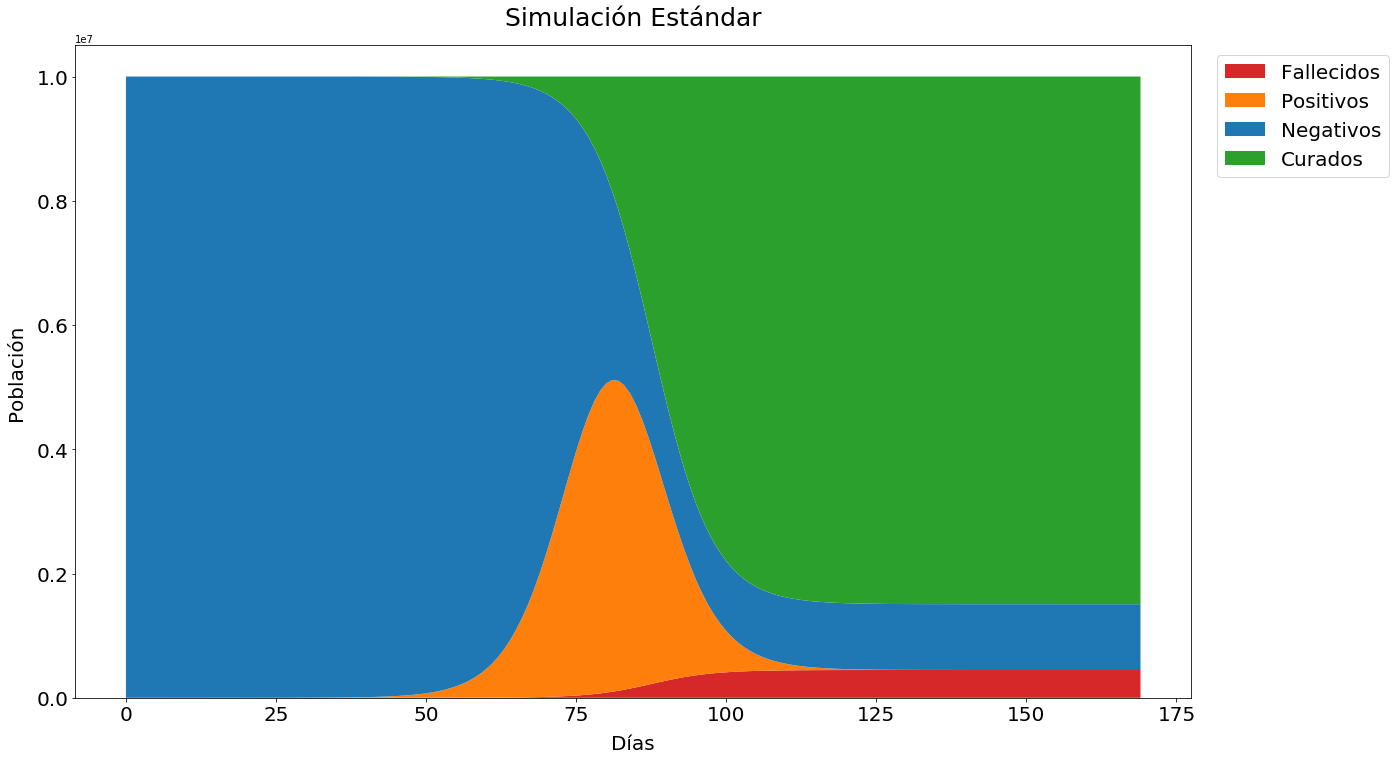

In [10]:
#Genera los individuos de la población
poblacion = generaPoblacion()

#Relaciones entre las personas 
relaciones = generaRelaciones ()

#Inicializa contagios
poblacion = inicializaContagios (poblacion)

#Simulación
resultados = simulacion (poblacion, relaciones)

#Guardamos los resultados para su posterior estudio
guardarExcel (resultados, 'Resultados.xlsx')

#Generamos los gráficos
generaGraficos(resultados, 'SimulaciónEstandar.png', 'Simulación Estándar')

## Repetimos el experimento pero esta vez reducimos las interacciones con personas #QuedateEnCasa

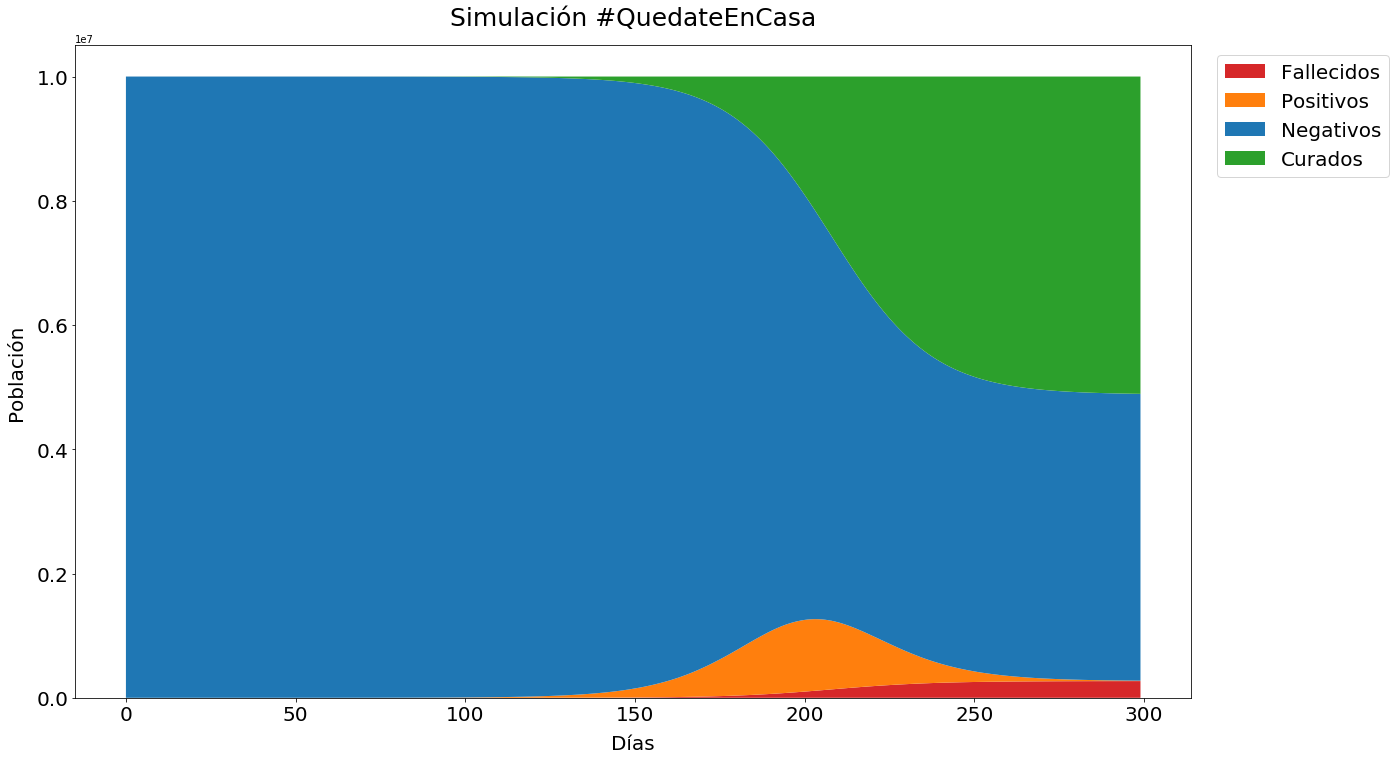

In [11]:
num_relaciones_min = 0
num_relaciones_max = 4

#Genera los individuos de la población
poblacion2 = generaPoblacion()

#Relaciones entre las personas, está vez menos relaciones al establecerse la cuarentena #QuedateEnCasa
relaciones2 = generaRelaciones ()

#Inicializa contagios
poblacion2 = inicializaContagios (poblacion2)

#Simulación
resultados2 = simulacion (poblacion2, relaciones2)

guardarExcel (resultados2, 'Resultados2.xlsx')

generaGraficos(resultados2, 'SimulaciónQuedateEnCasa.png', 'Simulación #QuedateEnCasa')